In [28]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import os

In [29]:
# 设置工作目录和读取预测数据
work_dir = r"F:\SJTU\2024-2025-1\ECON1501\Project\data"
file_path = os.path.join(work_dir, r"output-LGBM-A-cv=2.csv")  # 替换为实际路径
data = pd.read_csv(file_path, parse_dates=["date"])

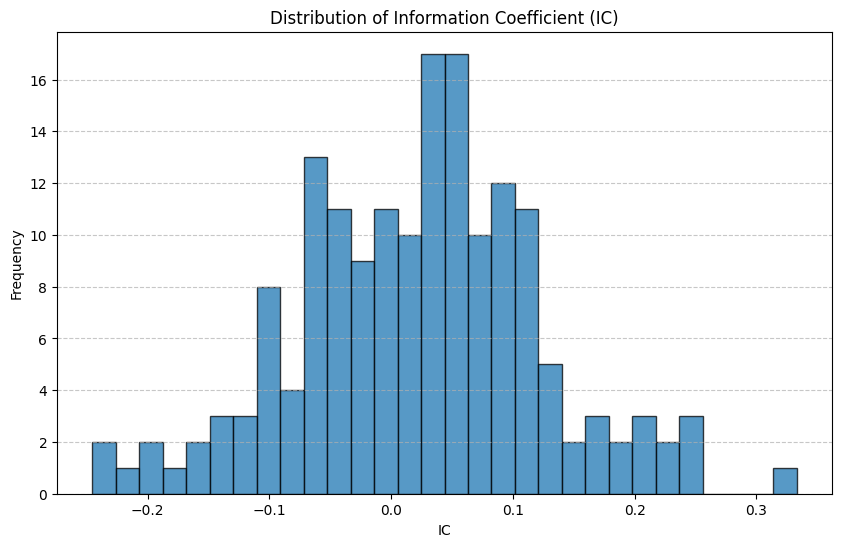

In [30]:
# 按年月分组计算 IC
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
ic_values = []

for (year, month), group in data.groupby(["year", "month"]):
    if len(group) > 1:
        ic, _ = spearmanr(group["stock_exret_pred"], group["actual_stock_exret"])
    else:
        ic = np.nan  # 如果样本量不足，无法计算 IC
    ic_values.append({"year": year, "month": month, "IC": ic})

# 转换为 DataFrame 并保存 IC 结果
ic_df = pd.DataFrame(ic_values)
ic_df["date"] = pd.to_datetime(ic_df[["year", "month"]].assign(day=1))
ic_df.to_csv(os.path.join(work_dir, "ic_results.csv"), index=False)

# 绘制 IC 分布图
plt.figure(figsize=(10, 6))
plt.hist(ic_df["IC"].dropna(), bins=30, alpha=0.75, edgecolor="black")
plt.title("Distribution of Information Coefficient (IC)")
plt.xlabel("IC")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig(os.path.join(work_dir, "ic_distribution.png"))
plt.show()

In [31]:
# 参数设置
model = "LightGBM_pred"
actual_return = "stock_exret_pred" 
min_stocks = 50
max_stocks = 100

# 分组逻辑：选取预测收益排名前/后的股票
def select_stocks(df, long_top=True, n_min=min_stocks, n_max=max_stocks):
    df = df.sort_values(model, ascending=not long_top)  # 按预测值排序
    selected = df.head(n_max) if len(df) > n_max else df
    if len(selected) < n_min:  # 如果不足最小数量，补充到 n_min
        selected = df.head(n_min)
    return selected

# 动态权重分配
def calculate_weights(df):
    abs_sum = df[model].abs().sum()
    if abs_sum > 0:
        df["weight"] = df[model] / abs_sum
    else:
        df["weight"] = 0

    # 限制权重范围，避免极端值
    df["weight"] = df["weight"].clip(lower=-0.1, upper=0.1)
    return df

# 分组数据并进行分析
results = []
for (year, month), group in data.groupby(["year", "month"]):
    # 长多策略
    long_stocks = select_stocks(group, long_top=True)
    long_stocks = calculate_weights(long_stocks)
    long_return = (long_stocks["weight"] * long_stocks[actual_return]).sum()

    # 短多策略
    short_stocks = select_stocks(group, long_top=False)
    short_stocks = calculate_weights(short_stocks)
    short_return = (short_stocks["weight"] * short_stocks[actual_return]).sum()

    # 多空策略
    long_short_return = long_return - short_return

    results.append({
        "year": year,
        "month": month,
        "long_return": long_return,
        "short_return": short_return,
        "long_short_return": long_short_return,
    })

# 转换为 DataFrame
results_df = pd.DataFrame(results)

# 计算累计收益
results_df["cumulative_long"] = (1 + results_df["long_return"]).cumprod() - 1
results_df["cumulative_short"] = (1 + results_df["short_return"]).cumprod() - 1
results_df["cumulative_long_short"] = (1 + results_df["long_short_return"]).cumprod() - 1

# 计算Sharpe Ratio
returns = results_df["long_short_return"]
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(12)  # 年化
print("Sharpe Ratio:", sharpe_ratio)

# 计算最大回撤
rolling_peak = results_df["cumulative_long_short"].cummax()
drawdown = rolling_peak - results_df["cumulative_long_short"]
max_drawdown = drawdown.max()
print("Maximum Drawdown:", max_drawdown)

# 计算Max 1-Month Loss
max_1m_loss = results_df["long_short_return"].min()
print("Max 1-Month Loss:", max_1m_loss)

# 保存结果
results_df.to_csv(os.path.join(work_dir, "strategy-LGBM-with-IC.csv"), index=False)
print("Results saved to strategy-LGBM-with-IC.csv")

Sharpe Ratio: -1.2713392500471297
Maximum Drawdown: 0.6986019609514771
Max 1-Month Loss: -0.14735188808109195
Results saved to strategy-LGBM-with-IC.csv


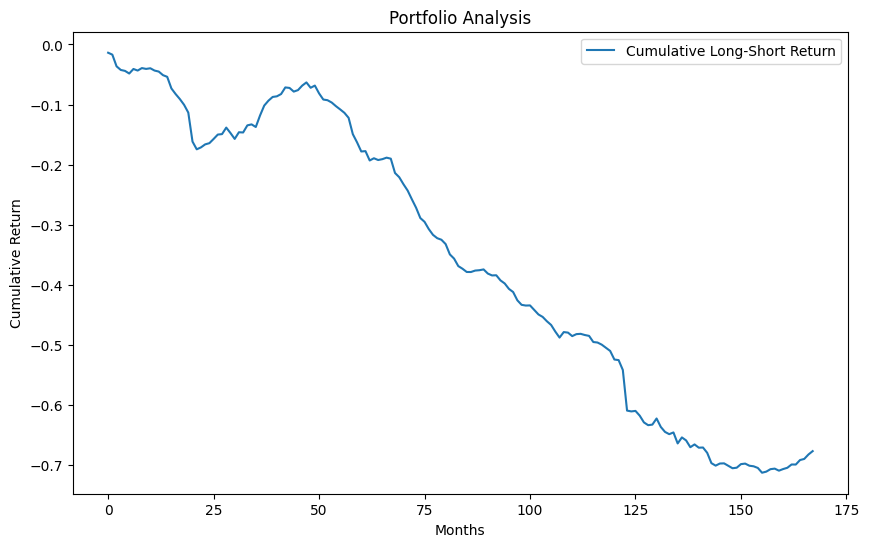

In [32]:
# 绘制累计收益图
plt.figure(figsize=(10, 6))
plt.plot(results_df["cumulative_long_short"], label="Cumulative Long-Short Return")
plt.title("Portfolio Analysis")
plt.xlabel("Months")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

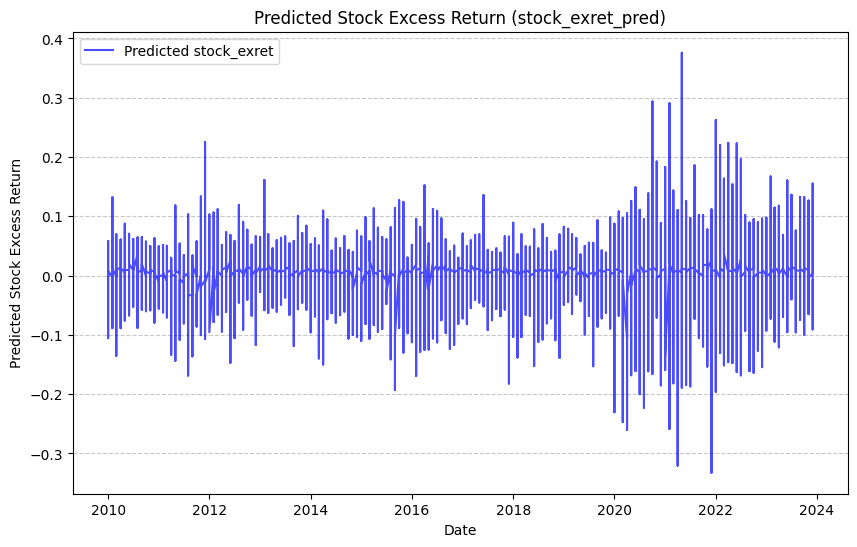

In [33]:
# 绘制 stock_exret_pred 的曲线
plt.figure(figsize=(10, 6))
data_sorted = data.sort_values("date")
plt.plot(data_sorted["date"], data_sorted["stock_exret_pred"], label="Predicted stock_exret", color="blue", alpha=0.7)
plt.title("Predicted Stock Excess Return (stock_exret_pred)")
plt.xlabel("Date")
plt.ylabel("Predicted Stock Excess Return")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.savefig(os.path.join(work_dir, "stock_exret_pred_curve.png"))
plt.show()

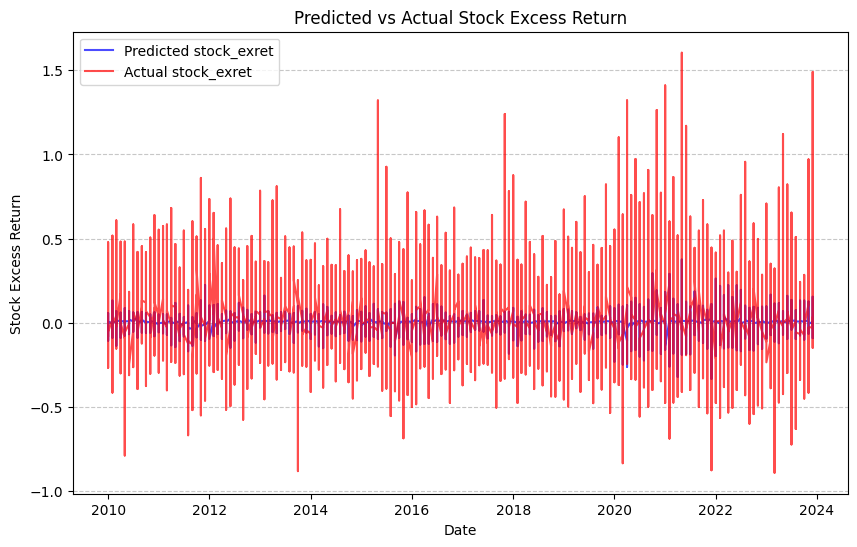

In [34]:
# 绘制 stock_exret_pred 和 actual_stock_exret 对比曲线
plt.figure(figsize=(10, 6))
plt.plot(data_sorted["date"], data_sorted["stock_exret_pred"], label="Predicted stock_exret", color="blue", alpha=0.7)
plt.plot(data_sorted["date"], data_sorted["actual_stock_exret"], label="Actual stock_exret", color="red", alpha=0.7)
plt.title("Predicted vs Actual Stock Excess Return")
plt.xlabel("Date")
plt.ylabel("Stock Excess Return")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.savefig(os.path.join(work_dir, "predicted_vs_actual_curve.png"))
plt.show()